In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras import callbacks
import os
import tensorflow as tf
from tensorflow.keras.models import load_model

In [ ]:
data_generator = ImageDataGenerator(rescale=1./255,
                                    rotation_range=30,
                                    zoom_range=0.15,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.15,
                                    horizontal_flip=True,
                                    fill_mode="nearest"
                                    )


# data_generator = ImageDataGenerator(rescale=1./255)

data_generat = ImageDataGenerator(rescale=1./255)

train_gen = data_generator.flow_from_directory("/content/drive/My Drive/pneumonia_detection_1/pneumonia-detection/train",
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               class_mode="categorical",
                                               batch_size=32,
                                               shuffle=True)

val_gen = data_generat.flow_from_directory("/content/drive/My Drive/pneumonia_detection_1/pneumonia-detection/validation",
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               class_mode="categorical",
                                               batch_size=32)

test_gen = data_generat.flow_from_directory("/content/drive/My Drive/pneumonia_detection_1/pneumonia-detection/test",
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               class_mode="categorical",
                                               batch_size=32)

Found 4682 images belonging to 3 classes.
Found 550 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


In [ ]:
mobilenet = tf.keras.applications.MobileNetV2(input_shape=(256,256,3),include_top=False,weights="imagenet")
X = Flatten()(mobilenet.output)
X = Dense(640, activation='relu')(X)
X = Dense(320, activation='relu')(X)
output = Dense(3, activation='softmax')(X)

model = Model(inputs=mobilenet.input, outputs=output)

for layer in mobilenet.layers:
  layer.trainable = False

9412608/9406464 [==============================] - 1s 0us/step


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
class CustomSaver(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch == 19 or epoch==39 or epoch==49:  # or save after some epoch, each k-th epoch etc.
            count = epoch+1
            self.model.save("/content/drive/My Drive/_mobilenet_aug/model_epoch_{}_loss_{}.h5".format(count, logs["loss"]))
            print("\nEpoch {} over. Saving model".format(count))

model_saver = CustomSaver()

In [ ]:
r = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50
    #callbacks=[model_saver]
)

Epoch 1/50
 12/147 [=>............................] - ETA: 32:32 - loss: 34.2823 - accuracy: 0.4115

KeyboardInterrupt: ignored

In [ ]:
model_50 = load_model("/content/drive/My Drive/pneumonia_mobilenet_aug/model_epoch_50_loss_0.4033724367618561.h5")

In [ ]:
model_40 = load_model("/content/drive/My Drive/pneumonia_mobilenet_aug/model_epoch_40_loss_0.417671263217926.h5")

In [ ]:
model_40.evaluate(test_gen)

20/20 [==============================] - 8s 394ms/step - loss: 0.4545 - accuracy: 0.8622


[0.4544748067855835, 0.8621794581413269]

In [ ]:
model.evaluate(test_gen)

20/20 [==============================] - 291s 15s/step - loss: 0.5147 - accuracy: 0.8510


[0.5146545767784119, 0.8509615659713745]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = np.zeros([624,])
y_test_full = np.zeros([624,])
for i in range(0, 20):
  (x_test, y_test) = test_gen[i]
  Y_pred = model_40.predict(x_test)
  y_test_full[32*i:32*i+32] = np.argmax(y_test, axis=1)
  y_pred[32*i:32*i+32] = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(y_test_full, y_pred)
print('Classification Report')
target_names = ['Bacterial Pneumonia', 'Normal', 'Viral Pneumonia']
print(classification_report(y_test_full, y_pred, target_names=target_names))

Confusion Matrix
Classification Report
                     precision    recall  f1-score   support

Bacterial Pneumonia       0.87      0.91      0.89       242
             Normal       0.89      0.88      0.89       234
    Viral Pneumonia       0.81      0.74      0.77       148

           accuracy                           0.86       624
          macro avg       0.85      0.85      0.85       624
       weighted avg       0.86      0.86      0.86       624



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = np.zeros([624,])
y_test_full = np.zeros([624,])
for i in range(0, 20):
  (x_test, y_test) = test_gen[i]
  Y_pred = model_50.predict(x_test)
  y_test_full[32*i:32*i+32] = np.argmax(y_test, axis=1)
  y_pred[32*i:32*i+32] = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(y_test_full, y_pred)
print('Classification Report')
target_names = ['Bacterial Pneumonia', 'Normal', 'Viral Pneumonia']
print(classification_report(y_test_full, y_pred, target_names=target_names))

Confusion Matrix
Classification Report
                     precision    recall  f1-score   support

Bacterial Pneumonia       0.84      0.93      0.88       242
             Normal       0.88      0.88      0.88       234
    Viral Pneumonia       0.83      0.68      0.74       148

           accuracy                           0.85       624
          macro avg       0.85      0.83      0.83       624
       weighted avg       0.85      0.85      0.85       624



In [ ]:
cm

In [ ]:
print(train_gen.class_indices)
print(val_gen.class_indices)
print(test_gen.class_indices)
# print(train_gen.classes)
# print(val_gen.classes)
# print(test_gen.classes)

{'Bacterial Pneumonia': 0, 'Normal': 1, 'Viral Pneumonia': 2}
{'Bacterial Pneumonia': 0, 'Normal': 1, 'Viral Pneumonia': 2}
{'Bacterial Pneumonia': 0, 'Normal': 1, 'Viral Pneumonia': 2}


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(test_gen)
y_pred = np.argmax(Y_pred, axis=-1)
print('Confusion Matrix')
print(confusion_matrix(test_gen.classes, y_pred))
print('Classification Report')
target_names = ['Bacterial Pneumonia', 'Normal', 'Viral Pneumonia']
print(classification_report(test_gen.classes, y_pred, target_names=target_names))

Confusion Matrix
[[102  89  51]
 [100  95  39]
 [ 66  51  31]]
Classification Report
                     precision    recall  f1-score   support

Bacterial Pneumonia       0.38      0.42      0.40       242
             Normal       0.40      0.41      0.41       234
    Viral Pneumonia       0.26      0.21      0.23       148

           accuracy                           0.37       624
          macro avg       0.35      0.35      0.35       624
       weighted avg       0.36      0.37      0.36       624



In [ ]:
Y_pred

array([[8.3134824e-01, 7.9113012e-03, 1.6074044e-01],
       [6.7410976e-01, 9.3047284e-02, 2.3284298e-01],
       [9.0276659e-02, 3.8042149e-04, 9.0934289e-01],
       ...,
       [5.2629137e-01, 5.0555370e-03, 4.6865302e-01],
       [4.4281352e-01, 2.1924567e-01, 3.3794084e-01],
       [1.2440862e-01, 6.9722341e-04, 8.7489420e-01]], dtype=float32)

In [ ]:
print(Y_pred.shape)
print(y_pred)

(624, 3)
[1 0 0 2 1 1 1 0 1 0 0 1 1 0 2 1 1 0 1 1 0 2 1 1 1 1 1 1 1 1 2 1 1 2 0 1 0
 2 0 1 0 0 0 0 1 1 0 2 2 0 2 2 2 2 1 2 0 1 2 1 2 0 1 0 2 0 2 1 0 1 1 0 2 2
 1 2 0 1 0 0 1 0 2 1 2 0 1 1 2 0 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0 0 2 1 0 1 2
 2 2 0 0 2 0 2 0 1 0 0 0 1 0 1 1 0 1 0 1 0 0 1 0 0 1 1 1 2 0 1 0 0 0 0 1 2
 2 2 0 2 0 0 0 1 0 1 2 0 0 0 1 1 0 2 1 0 1 1 0 1 0 0 0 0 1 0 2 2 1 1 1 1 0
 1 0 2 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 2 0 0 1 0 1 0 0 0 2 1 2 1 2 0
 0 1 0 0 0 1 2 2 1 0 0 0 1 2 2 1 1 1 1 0 1 1 0 1 0 2 1 0 1 0 0 0 1 0 0 0 0
 2 2 2 0 0 1 0 1 0 1 0 1 2 1 2 1 0 0 1 0 1 1 2 2 0 1 1 1 0 2 1 1 1 0 1 0 2
 1 1 0 1 0 0 0 0 0 1 1 1 0 0 1 1 0 1 1 0 2 1 0 1 1 0 1 0 1 0 0 0 0 0 2 0 0
 0 0 1 1 2 1 2 0 2 0 2 1 0 0 0 0 2 0 1 0 0 0 1 1 1 1 1 0 1 2 0 0 0 1 0 2 1
 1 0 0 0 1 0 0 1 0 1 2 1 0 2 0 1 0 2 0 0 1 2 0 0 0 1 2 1 0 1 0 2 2 2 0 0 0
 0 0 0 1 2 0 2 0 0 1 1 0 1 2 0 0 0 0 0 0 1 2 0 0 2 1 1 2 1 1 1 2 0 1 1 0 0
 0 0 1 2 1 1 0 2 1 1 1 2 0 1 2 1 2 2 0 1 0 1 0 1 0 1 1 0 0 1 1 2 1 1 2 0 0
 0 1 0 0 1 1 0 1

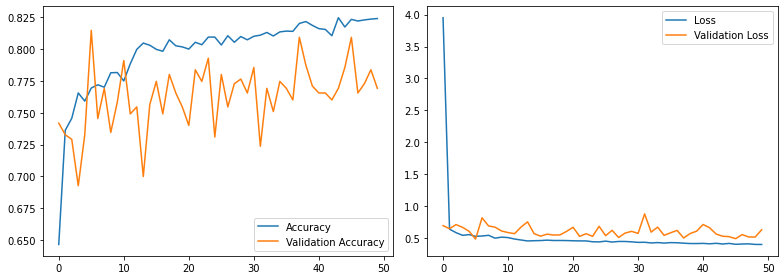

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,4))
axes[0].plot(r.history['accuracy'], label='Accuracy')
axes[0].plot(r.history['val_accuracy'], label='Validation Accuracy')
axes[0].legend()
#plt.show()
axes[1].plot(r.history['loss'], label='Loss')
axes[1].plot(r.history['val_loss'], label='Validation Loss')
axes[1].legend()
fig.tight_layout()

In [ ]:
accuracy = r.history['accuracy']
loss = r.history['loss']
val_accuracy = r.history['val_accuracy']
val_loss = r.history['val_loss']

In [ ]:
accuracy

[0.6467321515083313,
 0.7362238168716431,
 0.7456215023994446,
 0.7654848098754883,
 0.7590773105621338,
 0.7693293690681458,
 0.7718923687934875,
 0.7699701189994812,
 0.7812900543212891,
 0.7815036177635193,
 0.7748825550079346,
 0.788338303565979,
 0.7996582388877869,
 0.8045706748962402,
 0.8028620481491089,
 0.7996582388877869,
 0.7981631755828857,
 0.807133674621582,
 0.8024348616600037,
 0.801580548286438,
 0.7998718619346619,
 0.8052114248275757,
 0.8032891750335693,
 0.8092695474624634,
 0.8092695474624634,
 0.8030756115913391,
 0.810337483882904,
 0.8052114248275757,
 0.8096967339515686,
 0.807133674621582,
 0.8099102973937988,
 0.8107646107673645,
 0.8129004836082458,
 0.810123860836029,
 0.8133276104927063,
 0.8139683604240417,
 0.8137547969818115,
 0.8199487328529358,
 0.8214438557624817,
 0.8184536695480347,
 0.8158906698226929,
 0.8152499198913574,
 0.810337483882904,
 0.8244339823722839,
 0.8171721696853638,
 0.823152482509613,
 0.8218709826469421,
 0.8227253556251526,


In [ ]:
loss

[3.950165271759033,
 0.6422800421714783,
 0.5879874229431152,
 0.5464120507240295,
 0.5574573278427124,
 0.5310460329055786,
 0.5355070233345032,
 0.5464696288108826,
 0.5018845796585083,
 0.5180821418762207,
 0.5110071301460266,
 0.48836269974708557,
 0.47319573163986206,
 0.45810240507125854,
 0.46211835741996765,
 0.4645008444786072,
 0.4707063138484955,
 0.46536484360694885,
 0.46559780836105347,
 0.46449014544487,
 0.4610227942466736,
 0.4592163562774658,
 0.4586643576622009,
 0.4456588923931122,
 0.4433152675628662,
 0.4554717242717743,
 0.44125857949256897,
 0.4502543807029724,
 0.4499731659889221,
 0.44446268677711487,
 0.4360734224319458,
 0.43773987889289856,
 0.4270915985107422,
 0.43311378359794617,
 0.42492276430130005,
 0.432171493768692,
 0.43015310168266296,
 0.42353031039237976,
 0.41791731119155884,
 0.417671263217926,
 0.4201306700706482,
 0.41377928853034973,
 0.42140132188796997,
 0.4107528328895569,
 0.41966620087623596,
 0.40571266412734985,
 0.4104805290699005,


In [ ]:
val_accuracy

[0.7418181896209717,
 0.7327272891998291,
 0.7290909290313721,
 0.692727267742157,
 0.7327272891998291,
 0.8145454525947571,
 0.7454545497894287,
 0.7690908908843994,
 0.7345454692840576,
 0.7581818103790283,
 0.7909091114997864,
 0.7490909099578857,
 0.7545454502105713,
 0.699999988079071,
 0.7563636302947998,
 0.774545431137085,
 0.7490909099578857,
 0.7799999713897705,
 0.7654545307159424,
 0.7545454502105713,
 0.7400000095367432,
 0.7836363911628723,
 0.774545431137085,
 0.7927272915840149,
 0.7309091091156006,
 0.7799999713897705,
 0.7545454502105713,
 0.7727272510528564,
 0.7763636112213135,
 0.7654545307159424,
 0.7854545712471008,
 0.7236363887786865,
 0.7690908908843994,
 0.7509090900421143,
 0.774545431137085,
 0.7690908908843994,
 0.7599999904632568,
 0.8090909123420715,
 0.7872727513313293,
 0.7709090709686279,
 0.7654545307159424,
 0.7654545307159424,
 0.7599999904632568,
 0.7690908908843994,
 0.7854545712471008,
 0.8090909123420715,
 0.7654545307159424,
 0.772727251052856

In [ ]:
val_loss

[0.6981595158576965,
 0.650301456451416,
 0.7141810655593872,
 0.6714816689491272,
 0.6098067164421082,
 0.48784139752388,
 0.820073664188385,
 0.6932108998298645,
 0.6740608215332031,
 0.6137104630470276,
 0.5896533131599426,
 0.5723601579666138,
 0.676413357257843,
 0.7566880583763123,
 0.5721580386161804,
 0.5332213640213013,
 0.5646602511405945,
 0.5504651069641113,
 0.5536208152770996,
 0.6084241271018982,
 0.6722538471221924,
 0.529416024684906,
 0.5713672041893005,
 0.5302768349647522,
 0.6876763105392456,
 0.5405734777450562,
 0.6247848868370056,
 0.5125328302383423,
 0.581964373588562,
 0.608569860458374,
 0.5762587785720825,
 0.881757915019989,
 0.5964219570159912,
 0.6744961738586426,
 0.5455447435379028,
 0.5863105058670044,
 0.6236700415611267,
 0.5044517517089844,
 0.5743345618247986,
 0.6115338802337646,
 0.7156737446784973,
 0.6640703082084656,
 0.5664326548576355,
 0.5320910811424255,
 0.5254592895507812,
 0.49405139684677124,
 0.557534396648407,
 0.5207136869430542,
 

In [ ]:
print(len(accuracy),len(loss),len(val_accuracy),len(val_loss))

50 50 50 50


In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='MobileNetV2 with augmentation',
                          cmap=plt.cm.Blues):
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.savefig("mobile_net_with_aug_40_epoch.png")
  plt.show()


Confusion matrix, without normalization
[[221  18   3]
 [  4 207  23]
 [ 30   8 110]]


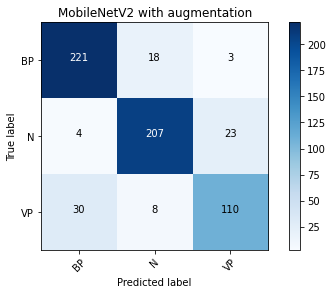

In [ ]:
# cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, ['BP','N', 'VP'])